# 04_1D_CNN + LSTM

In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import json
import time

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

## 1. 데이터불러오기

In [4]:
feature = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/feature.csv', index_col=[0])
target = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/target.csv', index_col=[0])

word_index_json = open('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/word_index_vocab.json', 'r').read()
word_index_vocab = json.loads(word_index_json)

In [5]:
feature_split = feature['댓글'].apply(list).tolist()

In [6]:
tokenizer = Tokenizer()
tokenizer.word_index = word_index_vocab

feature_sequences = tokenizer.texts_to_sequences(feature_split)

In [7]:
feature_input = pad_sequences(feature_sequences, padding='post', maxlen=400)

In [8]:
target.value_counts()

악플여부
0       76691
1       38128
dtype: int64

In [ ]:
# from imblearn.over_sampling import SMOTE

In [ ]:
# start = time.time()

# smote = SMOTE(random_state=123)
# train_over, y_train_over = smote.fit_sample(train, y_train)

# print("걸린시간 :", time.time() - start)

걸린시간 : 226.63439559936523


In [9]:
train_over = feature_input
y_train_over = np.array(target)

## 2. 1D-CNN + Bidirectional LSTM

In [10]:
import tensorflow.keras.backend as K
# Mish 활성화 함수
def mish(x):
    return x * K.tanh(K.softplus(x))

In [11]:
# 음절 단어사전의 크기
vocab_size = len(word_index_vocab)
embedding_dim = 128
comment_len = 400

In [13]:
def get_model() :

    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D, Dropout, Flatten, MaxPool1D, GlobalAveragePooling1D, Flatten, Bidirectional, LSTM, AveragePooling1D

    model = Sequential()
    model.add(Embedding(vocab_size+1, embedding_dim, input_length=comment_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 3, padding='same', activation=mish, strides=1))
    model.add(AveragePooling1D())
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

    return model


In [14]:
# 3-Fold 시행
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)

In [15]:
validation_pred = np.zeros((train_over.shape[0], 1))


k = 0
for train_idx, val_idx in tqdm_notebook(cv.split(train_over, y_train_over)) :

    print('{}번째 Fold 시작' .format(k+1))

    x_train = train_over[train_idx]
    y_train = y_train_over[train_idx]

    x_validation = train_over[val_idx]
    y_validation = y_train_over[val_idx]

    CNN_LSTM = get_model()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

    CNN_LSTM.fit(x_train, y_train,
                 callbacks          = [es],
                 epochs             = 20,
                 batch_size         = 64,
                 validation_data    = (x_validation, y_validation))
    
    validation_pred[val_idx, : ] = CNN_LSTM.predict(x_validation) 
    print('')

    k += 1

1번째 Fold 시작
Epoch 1/20
1197/1197 [==============================] - 52s 35ms/step - loss: 0.3584 - accuracy: 0.8465 - val_loss: 0.2083 - val_accuracy: 0.9232
Epoch 2/20
1197/1197 [==============================] - 41s 34ms/step - loss: 0.2045 - accuracy: 0.9252 - val_loss: 0.1857 - val_accuracy: 0.9303
Epoch 3/20
1197/1197 [==============================] - 41s 34ms/step - loss: 0.1784 - accuracy: 0.9335 - val_loss: 0.1819 - val_accuracy: 0.9346
Epoch 4/20
1197/1197 [==============================] - 41s 34ms/step - loss: 0.1812 - accuracy: 0.9347 - val_loss: 0.1817 - val_accuracy: 0.9349
Epoch 5/20
1197/1197 [==============================] - 40s 34ms/step - loss: 0.1704 - accuracy: 0.9390 - val_loss: 0.1798 - val_accuracy: 0.9359
Epoch 6/20
1197/1197 [==============================] - 40s 34ms/step - loss: 0.1725 - accuracy: 0.9369 - val_loss: 0.1779 - val_accuracy: 0.9350
Epoch 7/20
1197/1197 [==============================] - 40s 34ms/step - loss: 0.1674 - accuracy: 0.9407 - val_lo

## 3. ROC

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, make_scorer
import matplotlib.pyplot as plt

In [17]:
y_prob = validation_pred
y_test = y_train_over

AUC는? : 0.9683483


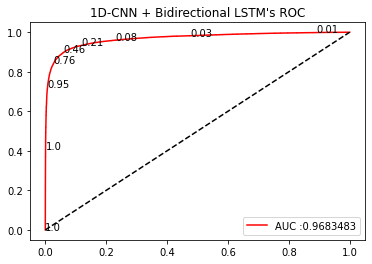

In [18]:
# Threshold변화에 따른 fpr, tpr의 변화
fpr_array, tpr_array, threshold_array = roc_curve(y_test, y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 2000)


# ROC 그래프 그리기
plt.plot(fpr_array, tpr_array, 
         c = 'red', 
         label = "AUC :" + str(round(roc_auc_score(y_test, y_prob), 7)))
plt.plot([0, 1], [0,1], ls='--', c='black')
plt.title("1D-CNN + Bidirectional LSTM's ROC")
plt.legend(loc=0)
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)


# ROC의 auc는?
print('AUC는? :', round(roc_auc_score(y_test, y_prob), 7))

## 4. ROC수치 저장

In [19]:
data = {
    'fpr_array'       : fpr_array,
    'tpr_array'       : tpr_array,
    'threshold_array' : threshold_array
}

df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/03_ROC_그래프/1D-CNN+Bidirectional LSTM_ROC.csv')